# Demo Data Generation for Payment-Processor AML Alerts
This notebook simulates merchant-month aggregates and computes features for AML alert scenarios in the payment-processor domain. It covers the following:
1. [Trigger] The number of all transactions in current month vs. past time frame for the merchant (peak activity)
2. [Trigger] An unusual spike in the number of reversals for merchant vs past time frame for the merchant
3. [Trigger] The total number of transactions with unusual currencies (infrequent currencies - not in the top 20 most used) 
4. [Trigger] Burst in number of terminals for merchant
5. Domestic vs. foreign transaction shift
6. Average transaction amount increase
7. Pipe account behaviour


### Init Context

In [1]:
from thetaray.api.context import init_context
from thetaray.common.data_environment import DataEnvironment
import datetime
import yaml

import logging
logging.basicConfig(level=logging.DEBUG, format='%(message)s')

with open('/thetaray/git/solutions/domains/demo_pay_proc/config/spark_config.yaml') as spark_config_file:
    spark_config = yaml.load(spark_config_file, yaml.FullLoader)['spark_config_a']
context = init_context(execution_date=datetime.datetime(1970, 1, 1),
                       spark_conf=spark_config,
                       spark_master='local[*]', delete_unused_columns=True
                       )

/thetaray/venv/lib64/python3.11/site-packages/starlette/config.py:60: UserWarning: Config file '.env' not found.
  warnings.warn(f"Config file '{env_file}' not found.")
/thetaray/venv/lib64/python3.11/site-packages/starlette/config.py:60: UserWarning: Config file '.env' not found.
  warnings.warn(f"Config file '{env_file}' not found.")
2025-08-11 18:21:52,257:INFO:thetaray.common.logging:start loading solution.....[ load_risks=True , solution_path=/thetaray/git/solutions/domains , settings_path=/thetaray/git/solutions/settings ]
2025-08-11 18:21:52,265:WARNING:thetaray.common.logging:Encryption is enabled on dataset demo_human_trafficking_insights, but data encryption is disabled in deployment
2025-08-11 18:21:52,280:WARNING:thetaray.common.logging:Encryption is enabled on dataset demo_remittance_customer_insights, but data encryption is disabled in deployment
2025-08-11 18:21:52,290:WARNING:thetaray.common.logging:Encryption is enabled on dataset demo_ret_smb_customer_insights, but da

Added `alias` successfully.


2025-08-11 18:22:24,325:INFO:thetaray.common.logging:=== Finished updating schema for Evaluation Flows on Minio ===


Added `alias` successfully.


### Imports

In [2]:
from thetaray.api.dataset import dataset_functions

from domains.demo_pay_proc.datasets.customer_monthly import customer_monthly_dataset
from domains.demo_pay_proc.datasets.customers import customers_dataset
from domains.demo_pay_proc.datasets.transactions import transactions_dataset

from pyspark.sql import functions as f

import logging
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import random
from faker import Faker
import uuid

faker = Faker()

### Data Generation

In [3]:
# ---------------- CONFIGURATION ----------------
NUM_MERCHANTS = 90
NUM_MONTHS = 12
CHANNELS = ['POS','Mobile']
fx_rates_normal = {
        'EUR': 0.8605, 'GBP': 0.7458, 'CHF': 0.8007, 'AUD': 1.5291,
        'CAD': 1.3687, 'JPY': 148.6521, 'NZD': 1.6773, 'SGD': 1.2822,
        'HKD': 7.8343, 'SEK': 9.6938, 'NOK': 10.2191, 'CNY': 7.1660,
        'INR': 85.6274, 'BRL': 5.5460, 'ZAR': 17.8383, 'MXN': 18.1732
    }
currency_mapping_normal = {
        'EUR': [('FR', 'France'), ('DE', 'Germany'), ('ES', 'Spain'), ('IT', 'Italy'), ('NL', 'Netherlands')],
        'GBP': [('GB', 'United Kingdom')],
        'CHF': [('CH', 'Switzerland')],
        'AUD': [('AU', 'Australia')],
        'CAD': [('CA', 'Canada')],
        'JPY': [('JP', 'Japan')],
        'NZD': [('NZ', 'New Zealand')],
        'SGD': [('SG', 'Singapore')],
        'HKD': [('HK', 'Hong Kong')],
        'SEK': [('SE', 'Sweden')],
        'NOK': [('NO', 'Norway')],
        'CNY': [('CN', 'China')],
        'INR': [('IN', 'India')],
        'BRL': [('BR', 'Brazil')],
        'ZAR': [('ZA', 'South Africa')],
        'MXN': [('MX', 'Mexico')],
    }
fx_rates_rare = {
        'NGN': 0.00065, 'ILS': 0.30, 'COP': 0.00025
    }
currency_mapping_rare = {
        'NGN': [('NG', 'Nigeria')],
        'ILS': [('IL', 'Israel')],
        'COP': [('CO', 'Colombia')]
    }
TYPE_CONFIG = {
    'Small': {'min_txn': 900, 'max_txn': 3000, 'avg_amount': (70, 150)}
}

ANOM_NAME = "Turner Group"
ANOM_MERCHANT = ANOM_NAME.replace(' ', '_').lower()
ANOM_LAST_MONTH = NUM_MONTHS-1
ANOM_OTHER_MONTH = NUM_MONTHS-5

In [4]:
# ---------------- FINAL TRANSACTION GENERATOR ----------------
def generate_transactions():
    merchants = []
    for i in range(NUM_MERCHANTS - 1):
        merchants.append({
            'customer_id': f'MERCHANT_{i:03d}',
            'customer_name': faker.company(),
            'merchant_category': random.choice(['Retail', 'Hospitality', 'Travel']),
            'type': 'Small'
        })
    merchants.append({
        'customer_id': ANOM_MERCHANT,
        'customer_name': ANOM_NAME,
        'merchant_category': 'Retail',
        'type': 'Small'
    })

    records = []
    today = pd.Timestamp(datetime.today().replace(day=1))
    periods = [today - pd.DateOffset(months=i) for i in range(NUM_MONTHS)]

    logging.info("Started records generation for all merchants.")

    for i, m in enumerate(merchants):
        cfg = TYPE_CONFIG[m['type']]
        if i in [25, 50, 75]:
            logging.info(f"{i}% of customers already generated.")

        for idx, period in enumerate(reversed(periods)):
            year_month = pd.to_datetime(period.strftime('%Y-%m'), format='%Y-%m')

            counterparties_pool = [{"id": str(uuid.uuid4()), "name": faker.company()} for _ in range(40)]

            # ------- Anomalous Merchant -------
            if m['customer_id'] == ANOM_MERCHANT and idx == ANOM_OTHER_MONTH - 1:  # March 
                txn_count = int(cfg['max_txn'] * 1)     # 1 x
                reversal_count = int(txn_count * 0.01)  # 2.7 x
                rare_count = int(txn_count * 0.02)      # 2 x
                terminals = [f'TERM-{j}' for j in range(15)] # 5 x 
                logging.info("Created subtle anomaly for March.")
            elif m['customer_id'] == ANOM_MERCHANT and idx == ANOM_LAST_MONTH:  # August major anomaly
                txn_count = int(cfg['max_txn'] * 3.5)      # 3.5 x
                reversal_count = int(txn_count * 0.004)  # 1 x
                rare_count = int(txn_count * random.uniform(0.005, 0.007))
                terminals = [f'TERM-{j}' for j in range(70)]  # 12 x
                logging.info("Created major anomaly for July.")
            elif m['customer_id'] == ANOM_MERCHANT and idx == ANOM_LAST_MONTH - 2:  # June anomaly
                txn_count = int(cfg['max_txn'] * 0.8)      # 1 x
                reversal_count = int(txn_count * 0.02)  # 1 x
                rare_count = int(txn_count * random.uniform(0.004, 0.007))
                terminals = [f'TERM-{j}' for j in range(50)]  # 12 x
                logging.info("Created major anomaly for July.")
            else:
                # Normal merchants: small noise, stable
                txn_count = int(random.randint(cfg['min_txn'], cfg['max_txn']) * random.uniform(0.98, 1.02))
                reversal_count = int(txn_count * random.uniform(0.0025, 0.004))
                rare_count = int(txn_count * random.uniform(0.005, 0.01))
                terminals = [f'TERM-{j}' for j in range(random.randint(1, 3))]

            reversal_indices = set(random.sample(range(txn_count), min(reversal_count, txn_count)))
            rare_indices = set(random.sample(range(txn_count), min(rare_count, txn_count)))

            for txn_i in range(txn_count):
                trx_ts = period + pd.Timedelta(days=random.randint(1, 28),
                                               hours=random.randint(0, 23),
                                               seconds=random.randint(0, 86400))
                amount_usd = np.random.uniform(*cfg['avg_amount'])
                is_domestic = random.random() < 0.8
                direction = random.choice(['IN', 'OUT'])
                is_rare_currency = False

                if is_domestic:
                    cp_cc, cp_cn = 'US', 'United States'
                    curr = 'USD'
                    amt_dom, amt_for = round(amount_usd, 2), round(amount_usd, 2)
                else:
                    curr = random.choice(list(currency_mapping_normal.keys()))
                    cp_cc, cp_cn = random.choice(currency_mapping_normal[curr])
                    rate = fx_rates_normal[curr]
                    amt_for = round(amount_usd / rate, 2)
                    amt_dom = round(amount_usd, 2)

                if txn_i in rare_indices:
                    curr = random.choice(list(currency_mapping_rare.keys()))
                    rate = fx_rates_rare[curr]
                    amt_for = round(amount_usd / rate, 2)
                    amt_dom = round(amount_usd, 2)
                    is_rare_currency = True

                ctpy_risks = (
                    'Moderate' if cp_cc in ['CN', 'BR', 'ZA', 'IN', 'MX']
                    else 'High' if cp_cc in ['NG', 'CO']
                    else 'Low'
                )

                # Assign random cp
                cp = random.choice(counterparties_pool)
                counterparty_id = cp["id"]
                counterparty_name = cp["name"]

                records.append({
                    'transaction_id': str(uuid.uuid4()),
                    'account_id': f"ACC-{m['customer_id']}",
                    'customer_id': m['customer_id'],
                    'customer_name': m['customer_name'],
                    'merchant_category': m['merchant_category'],
                    'transaction_timestamp': trx_ts,
                    'transaction_date': trx_ts.date(),
                    'year_month': year_month,
                    'amount_domestic_currency': amt_dom,
                    'amount_original_currency': amt_for,
                    'currency': curr,
                    'direction': direction,
                    'terminal_id': random.choice(terminals),
                    'transaction_type': 'payment' if txn_i not in reversal_indices else 'refund',
                    'transaction_description': 'Sale transaction' if txn_i not in reversal_indices else 'Refund transaction',
                    'transaction_channel': random.choice(CHANNELS),
                    'ip_address': faker.ipv4(),
                    'counterparty_id': counterparty_id,
                    'counterparty_name': counterparty_name,
                    'counterparty_country_code': cp_cc,
                    'counterparty_country_name': cp_cn,
                    'counterparty_country_risk': ctpy_risks,
                    'is_domestic': is_domestic,
                    'is_reversal': txn_i in reversal_indices,
                    'is_rare_currency': is_rare_currency,
                })

    logging.info("Finished generating all records.")
    return pd.DataFrame(records)

In [5]:
# ---------------- AGGREGATE FEATURES WITH ROBUST Z-SCORE ----------------
def aggregate_features(df):
    agg = df.groupby(['customer_id', 'year_month']).agg(
        customer_name=('customer_name', 'first'),
        txn_count=('transaction_id', 'count'),
        reversals=('is_reversal', 'sum'),
        rare_currency_count=('is_rare_currency', 'sum'),
        terminals=('terminal_id', lambda x: len(set(x))),
        avg_amount=('amount_domestic_currency', 'mean'),
        domestic_ratio=('is_domestic', 'sum')
    ).reset_index()

    agg['population_txn_count'] = int(random.randint(TYPE_CONFIG['Small']['min_txn'],
                                                     TYPE_CONFIG['Small']['max_txn']) * random.uniform(0.98, 1.02))
    agg['population_reversals'] = int(random.randint(TYPE_CONFIG['Small']['min_txn'],
                                                     TYPE_CONFIG['Small']['max_txn']) * random.uniform(0.0025, 0.004))

    features = []
    for cust in agg['customer_id'].unique():
        sub = agg[agg['customer_id'] == cust].copy().sort_values('year_month')
        for i in range(len(sub)):
            if i == 0:
                continue
            hist = sub.iloc[:i]
            window = hist.tail(6)
            curr = sub.iloc[i]

            txn_ratio = round(max((curr.txn_count - (window.txn_count.mean() or 1)) / (window.txn_count.mean() or 1), 0), 4)
            rev_ratio = round(max((curr.reversals - (window.reversals.mean() or 1)) / (window.reversals.mean() or 1), 0), 4)
            rare_pct = round(max((curr.rare_currency_count - (window.rare_currency_count.mean() or 1)) / (window.rare_currency_count.mean() or 1), 0), 4)
            term_ratio = round(max((curr.terminals - (window.terminals.mean() or 1)) / (window.terminals.mean() or 1), 0), 4)

            amt_ratio = round(max((curr.avg_amount - (window.avg_amount.mean() or 1)) / (window.avg_amount.mean() or 1), 0), 4)
            dom_change = round(curr.domestic_ratio / curr.txn_count, 4)
            pipe_score = round(random.uniform(0.1, 0.2), 4)

            features.append({
                'customer_id': cust,
                'customer_name': curr.customer_name,
                'year_month': curr.year_month,
                'year_month_str': curr.year_month.strftime('%Y-%m'),
                # forensic
                'txn_count': curr.txn_count,
                'population_txn_count': curr.population_txn_count,
                'avg_amount': curr.avg_amount,
                'terminals': curr.terminals,
                'reversals': curr.reversals,
                'population_reversals': curr.population_reversals,
                'rare_currency_count': curr.rare_currency_count,
                # features
                'txn_count_ratio': txn_ratio,
                'reversal_ratio': rev_ratio,
                'rare_currency_pct': rare_pct,
                'new_terminal_ratio': term_ratio,
                'avg_txn_amt_ratio': amt_ratio,
                'domestic_ratio_change': dom_change,
                'pipe_account_behaviour_score': pipe_score
            })

    return pd.DataFrame(features).fillna(0)

In [6]:
# ---------------- KYC GENERATION ----------------
def generate_kyc():
    return pd.DataFrame([{
        'customer_id': ANOM_MERCHANT,
        'customer_name': ANOM_NAME,
        'customer_mcc_code': '5411', 
        'registration_id': faker.bothify('REG-#######'),
        'incorporation_date': faker.date_between(start_date='-15y', end_date='-2y'),
        'customer_country_id': 'US',
        'customer_country_name': 'United States',
        'tax_residence': 'US',
        'industry': 'Retail',
        'expected_revenue': "$2M-5M", 
        'number_employees': random.randint(30, 90),  
        'aml_risk_rating': random.randint(3, 6),  
        'primary_payment_channels': 'POS, Mobile',
        'onboarding_date': faker.date_between(start_date='-10y', end_date='-1y'),
        'kyc_review_date': faker.date_between(start_date='-1y', end_date='today'),
        'pep_flag': False,
        'sanctions_check_status': 'Clear',
        'expected_transaction_volume': "1000-3000 transactions per month",
        'average_ticket_size': f"${random.randint(70, 150)}",
        'jurisdiction_risk_level': 'Low',
        'risk_drivers': 'Moderate transaction volumes; multiple terminals across stores',
        'ownership_structure': 'Privately Held',
        'compliance_officer_assigned': faker.name()
    }])


In [7]:
# ---------------- VISUAL CHECKS ----------------
def plot_checks(transactions_df, variable, aggregation):
    anom_txn = transactions_df[transactions_df.customer_id==ANOM_MERCHANT]
    normal_txn = transactions_df[transactions_df.customer_id!=ANOM_MERCHANT]

    plt.figure(figsize=(6, 3))
    normal_txn.groupby(['year_month', 'customer_id'])[variable].agg(aggregation).groupby('year_month').mean().plot(label='Normal Merchants (Avg)')
    normal_txn.groupby(['year_month', 'customer_id'])[variable].agg(aggregation).groupby('year_month').max().plot(linestyle='dashed',
                                                                                                                 label='Normal Merchants (Max)')
    anom_txn.groupby('year_month')[variable].agg(aggregation).plot(label='Anomalous Merchant')
    plt.title(f'Monthly {variable} {aggregation} Distribution')
    plt.legend()
    plt.show()

In [8]:
transactions_df = generate_transactions()

2025-08-11 18:22:26,052:INFO:root:Started records generation for all merchants.
2025-08-11 18:23:06,600:INFO:root:25% of customers already generated.
2025-08-11 18:23:45,700:INFO:root:50% of customers already generated.
2025-08-11 18:24:22,871:INFO:root:75% of customers already generated.
2025-08-11 18:24:44,995:INFO:root:Created subtle anomaly for March.
2025-08-11 18:24:45,414:INFO:root:Created major anomaly for July.
2025-08-11 18:24:45,709:INFO:root:Created major anomaly for July.
2025-08-11 18:24:46,329:INFO:root:Finished generating all records.


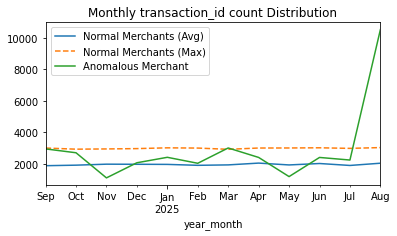

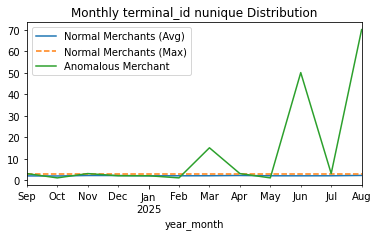

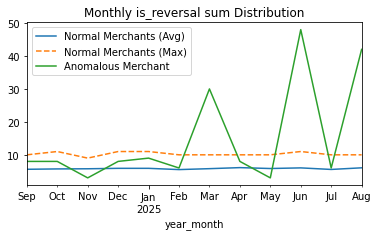

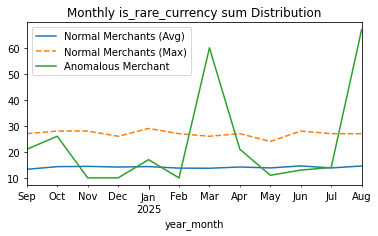

In [9]:
plot_checks(transactions_df, 'transaction_id', 'count')
plot_checks(transactions_df, 'terminal_id', 'nunique')
plot_checks(transactions_df, 'is_reversal', 'sum')
plot_checks(transactions_df, 'is_rare_currency', 'sum')

In [10]:
#from domains.demo_pay_proc.datasets.transactions import transactions_dataset as dataset
#transactions_df = dataset_functions.read(context, dataset().identifier, data_environment=DataEnvironment.PUBLIC).drop('tr_timestamp').toPandas()

In [11]:
aggregated_df = aggregate_features(transactions_df)
aggregated_df

,customer_id,customer_name,year_month,year_month_str,txn_count,population_txn_count,avg_amount,terminals,reversals,population_reversals,rare_currency_count,txn_count_ratio,reversal_ratio,rare_currency_pct,new_terminal_ratio,avg_txn_amt_ratio,domestic_ratio_change,pipe_account_behaviour_score
0,MERCHANT_000,Johnson Ltd,2024-10-01,2024-10,2904,2306,110.421329,2,10,2,19,0.1653,0.2500,0.0000,0.0000,0.0000,0.7989,0.1497
1,MERCHANT_000,Johnson Ltd,2024-11-01,2024-11,1360,2306,109.450397,1,3,2,12,0.0000,0.0000,0.0000,0.0000,0.0000,0.8147,0.1824
2,MERCHANT_000,Johnson Ltd,2024-12-01,2024-12,1830,2306,109.942656,3,6,2,16,0.0000,0.0000,0.0000,0.5000,0.0000,0.7858,0.1422
3,MERCHANT_000,Johnson Ltd,2025-01-01,2025-01,1027,2306,109.399786,1,2,2,8,0.0000,0.0000,0.0000,0.0000,0.0000,0.7819,0.1908
4,MERCHANT_000,Johnson Ltd,2025-02-01,2025-02,2402,2306,109.570400,2,6,2,15,0.2493,0.0345,0.0000,0.0000,0.0000,0.7864,0.1929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,castaneda_group,Castaneda Group,2025-04-01,2025-04,2401,2306,109.743744,3,8,2,21,0.0828,0.0000,0.0000,0.0000,0.0013,0.7951,0.1253
986,castaneda_group,Castaneda Group,2025-05-01,2025-05,1187,2306,109.795510,1,3,2,11,0.0000,0.0000,0.0000,0.0000,0.0013,0.8045,0.1910
987,castaneda_group,Castaneda Group,2025-06-01,2025-06,2400,2306,109.054525,50,48,2,13,0.1001,3.5000,0.0000,11.5000,0.0000,0.8004,0.1955
988,castaneda_group,Castaneda Group,2025-07-01,2025-07,2236,2306,110.633104,3,6,2,14,0.0000,0.0000,0.0000,0.0000,0.0102,0.7947,0.1752


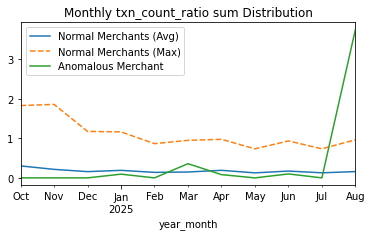

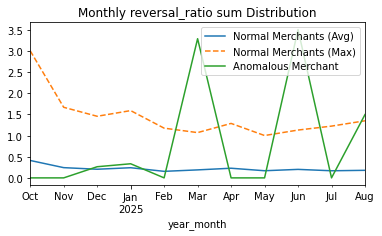

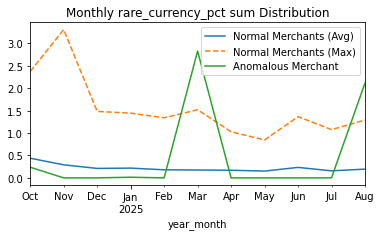

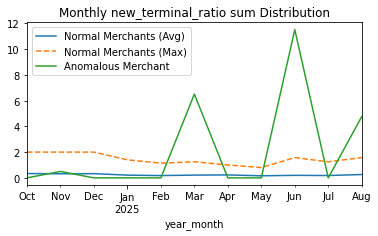

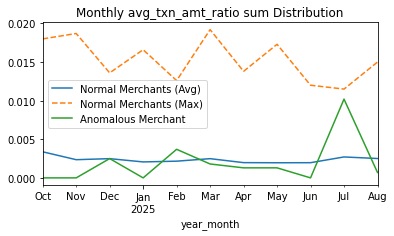

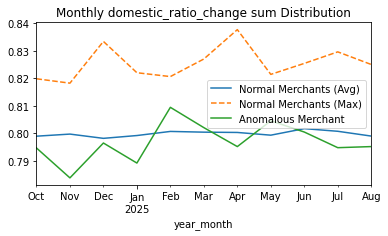

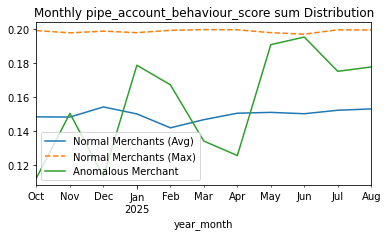

In [12]:
# trigger features
plot_checks(aggregated_df, 'txn_count_ratio', 'sum')  # since it's already at customer  and year-month level, param agg does not affect
plot_checks(aggregated_df, 'reversal_ratio', 'sum')
plot_checks(aggregated_df, 'rare_currency_pct', 'sum')
plot_checks(aggregated_df, 'new_terminal_ratio', 'sum')

# non-trigger features
plot_checks(aggregated_df, 'avg_txn_amt_ratio', 'sum')
plot_checks(aggregated_df, 'domestic_ratio_change', 'sum')
plot_checks(aggregated_df, 'pipe_account_behaviour_score', 'sum')

In [13]:
kyc_df = generate_kyc()
kyc_df

,customer_id,customer_name,customer_mcc_code,registration_id,incorporation_date,customer_country_id,customer_country_name,tax_residence,industry,expected_revenue,...,onboarding_date,kyc_review_date,pep_flag,sanctions_check_status,expected_transaction_volume,average_ticket_size,jurisdiction_risk_level,risk_drivers,ownership_structure,compliance_officer_assigned
0,castaneda_group,Castaneda Group,5411,REG-4932291,2022-05-24,US,United States,US,Retail,$2M-5M,...,2020-05-21,2024-11-01,False,Clear,1000-3000 transactions per month,$132,Low,Moderate transaction volumes; multiple termina...,Privately Held,Philip Mcdowell


In [14]:
dataset_functions.write(context, context.get_spark_session().createDataFrame(aggregated_df), customer_monthly_dataset().identifier, data_environment=DataEnvironment.PUBLIC)
dataset_functions.publish(context, customer_monthly_dataset().identifier, data_environment=DataEnvironment.PUBLIC)

2025-08-11 18:24:58,819:INFO:thetaray.common.logging:### DataSet - writing started ###
2025-08-11 18:25:03,593:INFO:thetaray.common.logging:### DataSet - writing done, 990 written, 0 corrupted, 0 rejected  ###
2025-08-11 18:25:06,532:INFO:thetaray.common.logging:finished publishing records for dataset demo_pay_proc_customer_monthly 


True

In [15]:
dataset_functions.write(context, context.get_spark_session().createDataFrame(transactions_df), transactions_dataset().identifier, data_environment=DataEnvironment.PUBLIC)
dataset_functions.publish(context, transactions_dataset().identifier, data_environment=DataEnvironment.PUBLIC)

2025-08-11 18:25:11,592:INFO:thetaray.common.logging:### DataSet - writing started ###
2025-08-11 18:25:33,313:INFO:thetaray.common.logging:### DataSet - writing done, 2119875 written, 0 corrupted, 0 rejected  ###
2025-08-11 18:26:52,493:INFO:thetaray.common.logging:finished publishing records for dataset demo_pay_proc_transactions 


True

In [16]:
dataset_functions.write(context, context.get_spark_session().createDataFrame(kyc_df), customers_dataset().identifier, data_environment=DataEnvironment.PUBLIC)
dataset_functions.publish(context, customers_dataset().identifier, data_environment=DataEnvironment.PUBLIC)

2025-08-11 18:26:52,520:INFO:thetaray.common.logging:### DataSet - writing started ###
25/08/11 18:26:54 ERROR FileUtils: Failed to delete s3a://thetaray-sonar/warehouse/public.db/demo_pay_proc_customers/tr_year=1970/tr_month=1/tr_day=1/tr_date=1970_01_01_00_00_00
2025-08-11 18:26:55,487:INFO:thetaray.common.logging:### DataSet - writing done, 1 written, 0 corrupted, 0 rejected  ###
2025-08-11 18:26:56,216:INFO:thetaray.common.logging:finished publishing records for dataset demo_pay_proc_customers 


True

In [17]:
context.close()